# Librerias y funciones previas

Comencemos cargando las librerías que usaremos a lo largo del trabajo, y definiendo todas las funciones necesarias.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Las próximas funciones las obtuvimos del whitepaper de Balancer (o de la propia dev doc del protocolo). A saber

- OutGivenIn: Devuelve la cantidad A_o (o = out) del token j = 1-i que obtendríamos si metiéramos al pool A_i (i = in) unidades del token i.
- InGivenOut: Devuelve la cantidad A_i del token j = 1-i que habría que meter al pool para obtener A_o unidades del token i.
- InGivenPrice: Devuelve la cantidad del token j = 1-i que habría que meter al pool si queremos cambiar el precio del pool P_pool a un nuevo precio P_new, metiendo el token i.

In [ ]:
def OutGivenIn(balance, A_i, i):
  '''
  P_ETH = balance[0] / balance[1]
  i = 0 quiere decir que meto USDC
  '''
  B_i = balance[i]
  B_o = balance[i-1]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_o = B_o * (1-B_i/(B_i+A_i))
  return A_o

def InGivenOut(balance, A_o, i):
  B_i = balance[i]
  B_o = balance[i-1]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_i = B_i * (B_o/(B_o-A_o)-1)
  return A_i 

def InGivenPrice(balance, P_new, i):
  P_pool = balance[0] / balance[1]
  B_i = balance[i]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_i = B_i * ((P_new/P_pool)**(1/2)-1)
  return A_i

La idea para emular los cambios en los balances del pool va a ser la siguiente:
- Dado un nuevo precio de mercado (de la data historica) vamos a comparar el precio del pool con el precio de mercado para saber cuál es más alto y ver qué moneda (i=0 USDC, i=1 wETH) debemos ingresar al pool para cambiar el precio relativo. Para eso usaremos la funcion InGivenPrice;
- Sabiendo la cantidad $A_i$ del token $i$ que debemos ingresar al pool, utilizaremos la función OutGivenIn para saber cuántas unidades $A_o$ del token o recibiremos por el swap;
- Finalmente teniendo ahora sí cuántas unidades del token i metimos al pool y cuántas unidades del token o sacamos del pool, podremos actualizar los balances.


Definimos entonces las siguientes funciones

- variacion_balances(balance_nuevo, balance_anterior): Devuelve la variacion como porcentaje (pcg) y en unidades, entre los dos balances que le pasemos. Usaremos esta función para calcular la variacion de los balances y aplicar estos cambios a nuestras tenencias. Otra forma sería directamente quedarnos con el % de nuestra participación en el pool para cada balance simulado.
- new_balance(P_new, balance_anterior): Devuelve el nuevo balance del pool dados el nuevo precio de mercado y el balance anterior. Esta función encierra la lógica que describimos en el párrafo anterior.
[Ej: Si ETH se valoriza en el mercado, entonces el pool tiene que reducir el balance de ETH. Con lo cual uno podría calcular cuánto USDC hay que meter para cambiar P_pool a P_new (InGivenPrice) y luego para ese A_i, calcular cuántos A_o ETH recibiría por esos A_i USDC (OutGivenIn). Finalmente, sumamos A_i al balance de USDC, restamos A_o al balance de ETH y tenemos el nuevo balance]

In [ ]:
def variacion_balances(balance_nuevo, balance_anterior):
  r_USDC = balance_nuevo[0] / balance_anterior[0] -1
  r_ETH = balance_nuevo[1] / balance_anterior[1] -1
  return {'pcg': [r_USDC, r_ETH],
          'unidades': [balance_nuevo[0]-balance_anterior[0], balance_nuevo[1]-balance_anterior[1]]}
def new_balance(P_new, balance_anterior):
  P_pool = balance_anterior[0] / balance_anterior[1]
  if P_pool < P_new: # ETH se apreció en el mercado, entonces tiene que bajar su balance y subir el de USDC
    A_i = InGivenPrice(balance_anterior, P_new, 0)
    A_o = OutGivenIn(balance_anterior, A_i, 0)
    return [balance_anterior[0] + abs(A_i), balance_anterior[1] - abs(A_o)]
  else: # si ETH se deprecia en el mercado, tiene que subir su balance
    A_i = InGivenPrice(balance_anterior, P_new, 1)
    A_o = OutGivenIn(balance_anterior, A_i, 1)
    return [balance_anterior[0] - abs(A_o), balance_anterior[1] + abs(A_i)]

Por último, definimos las funciones de Impermanent Loss como % y en USD, en términos de $R=\frac{P}{P_0}$ y de $P$, dadas por

\begin{align*}
  IL_{\%}(R) &= \frac{2\sqrt{R}}{R+1} -1 \Rightarrow IL_{USD}(R) = IL_{\%}(R)*V_{Hold};\\
  IL_{\%}(P) &= 2\sqrt{P_0}\frac{\sqrt{P}}{P+P_0}-1 \Rightarrow IL_{USD}(P) = IL_{\%}(P)*V_{Hold};\\ 
\end{align*}

Hay otra escritura posible para $IL_{USD}(P)$ que sale usando

\begin{align*}
  V_P &= 2\sqrt{kP} = 2\sqrt{kP_0}\sqrt{\frac{P}{P_0}} = V_P^0\sqrt{\frac{P}{P_0}},\\
  V_H &= \sqrt{kP_0}\left(\frac{P}{P_0}+1\right) = 2\sqrt{kP_0}\frac{1}{2}\left(\frac{P}{P_0}+1\right)=\frac{V_H^0}{2}\left(\frac{P}{P_0}+1\right).
\end{align*}

Notar que en las últimas identidades estamos usando $k(t)=k(0)$, que podría no ser cierto (Ver sección ¿Es lo mismo calcular IL como la diferencia entre V_P y V_H que tomar las formulas? NO!).

Nos queda entonces

$$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right).$$

**Observación** 

Como la idea es hedgearse contra el cambio en la IL respecto de cambios en el precio, debemos expresarla como función de $P$. Además, nos interesa manejar esa pérdida en términos de USDC y no como un ratio.

In [ ]:
def IL_R(R):
  return 2 * R**(1/2)/(R+1)-1
def IL_P(P):
  # return IL_R(P/P_entry)
  return 2 * (P_entry)**(1/2) * P**(1/2)/(P+P_entry)-1
def IL_R_in_usd(R):
  P = R * P_entry
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  return IL_R(R) * V_hold
def IL_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  # V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  # return IL_R_in_usd(P/P_entry)
  return IL_P(P) * V_hold
  # return V_hold_0 * ((P/P_entry)**(1/2) - 1/2 - P/(2*P_entry))


Podemos entonces calcular la derivada de IL

\begin{align*}
  \frac{\partial}{\partial R}IL_{\%}(R) &= \frac{1-R}{\sqrt{R}(R+1)^2}; \
  \frac{\partial}{\partial P}IL_{\%}(P) = \sqrt{P_0}\frac{P_0-P}{\sqrt{P}(P+P_0)^2} \\ 
  \Rightarrow \frac{\partial}{\partial P}IL_{USD}(P) &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * \frac{\partial}{\partial P}V_{Hold}\\
  &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * b,
\end{align*}
donde en la última identidad usamod $V_{Hold} = tenencias\_inicial[0] + tenencias\_inicial[1] * P =: a + b*P$.

Equivalentemente, si usamos $$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right),$$
nos queda
$$\frac{\partial}{\partial P}IL_{USD}(P) = \frac{V^0_H}{2P_0}\left(\sqrt{\frac{P_0}{P}}-1\right).$$

In [ ]:
#
def IL_derivada_R(R):
  return (1-R) / (R**(1/2)*(R+1)**2)
def IL_derivada_P(P):
  return IL_derivada_R(P/P_entry) / P_entry
  # return (P_entry)**(1/2)*(P_entry-P)/(P**(1/2)*(P+P_entry)**2)
def IL_derivada_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  return IL_derivada_P(P) * V_hold + IL_P(P) * tenencias_inicial[1]
  # return V_hold_0/(2*P_entry) * ((P_entry/P)**(1/2) - 1)

Agregamos también las fórmulas incorporando fees. Sean $fee=\tau$, $\phi = 1-\tau$, $P:=p^{bid^1}$ y $P_0:=p^{bid^0}$. Sabiendo que $p^b = \phi P_{Y|X} = \phi \frac{y}{x}$, $R=\frac{P_{Y|X}}{P^0_{Y|X}}=\frac{p^b}{p^b_0}$ y que $V_{Hold} = a+b*p^b$, tenemos

\begin{align*}
  IL^{fee}_{\%}(R) &= \sqrt{R}\frac{1+\phi}{\phi R+1} -1 \Rightarrow \frac{\partial}{\partial R}IL^{fee}_{\%}(R) = \frac{1+\phi}{(1+\phi R)^2}\frac{1-\phi R}{2\sqrt{R}};\\
  IL^{fee}_{\%}(P) &= \sqrt{PP_0}\frac{1+\phi}{P_0+\phi P}-1 \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{\%}(P) = \frac{1+\phi}{2}\sqrt{\frac{P_0}{P}}\frac{P_0-\phi P}{(P_0+\phi P)^2};\\ 
  IL^{fee}_{USD}(P) &= IL^{fee}_{\%}(P)*V_{Hold} \text{ una forma} \\
  &= \frac{V_H^0}{2}\left(\sqrt{\frac{P}{P_0}}\frac{1+\phi}{\phi}-\frac{P_0+\phi P}{P_0\sqrt{\phi}}\right) \text{ otra forma} \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{USD}(P) = \frac{V_H^0}{2P_0}\left(\frac{1}{2}\sqrt{\frac{P_0}{P}}\frac{1+\phi}{\phi}-\sqrt{\phi}\right).
\end{align*}

In [ ]:
def IL_R_fee(R,fee):
  phi = 1-fee
  return R**(1/2)*(1+phi)/(1+R*phi)-1
def IL_P_fee(P,fee):
  phi = 1-fee
  return IL_R_fee(P/P_entry,fee)
  # return (P*P_entry)**(1/2)*(1+phi)/(P_entry+phi*P)-1
def IL_P_in_usd_fee(P,fee):
  phi = 1-fee
  # P = R * P_entry
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  # p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return V_hold_0/2 * ( (p_bid/p_bid_entry)**(1/2) * (1+phi)/phi - (p_bid_entry + phi*p_bid) / (p_bid_entry*phi**(1/2)) )
  # return IL_R_in_usd_fee(P/P_entry,fee)
#
def IL_derivada_R_fee(R, fee):
  phi = 1-fee
  return (1+phi)/(1+phi*R)**2 * (1-phi*R)/(2*R**(1/2))
def IL_derivada_P_fee(P,fee):
  phi = 1-fee
  p_bid_entry = P_entry * phi
  p_bid = P *  phi
  return IL_derivada_R_fee(P/P_entry, fee) / p_bid_entry
  # return (1+phi)/2 * (p_bid_entry/p_bid)**(1/2) * (p_bid_entry-phi*p_bid)/(p_bid_entry+phi*p_bid)**2
def IL_derivada_P_in_usd_fee(P,fee):
  phi = 1-fee
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return IL_derivada_P_fee(P,fee) * V_hold + IL_P_fee(P, fee) * tenencias_inicial[1] 
  # return V_hold_0/(2*p_bid_entry) * ( 1/2*(p_bid_entry/p_bid)**(1/2) * (1+phi)/phi - phi**(1/2) )

Hacemos algunos plots para chequear que todas las formulaciones son, al menos graficamente, equivalentes.

In [ ]:
R_minus = np.arange(0.01, 1, 0.01)
R_plus = np.arange(1, 10, 0.01)

In [ ]:
# fig, axs = plt.subplots(1,1,figsize = (20,7))
# axs.plot(R_minus, IL_R(R_minus), c='red')
# axs.plot(R_plus, IL_R(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P(R_plus*P_entry), c='blue')
# axs.plot(R_minus, IL_R_in_usd(R_minus), c='red')
# axs.plot(R_plus, IL_R_in_usd(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs.plot(R_minus, IL_R_fee(R_minus, fee), c='red')
# axs.plot(R_plus, IL_R_fee(R_plus, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_fee(R_plus*P_entry, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

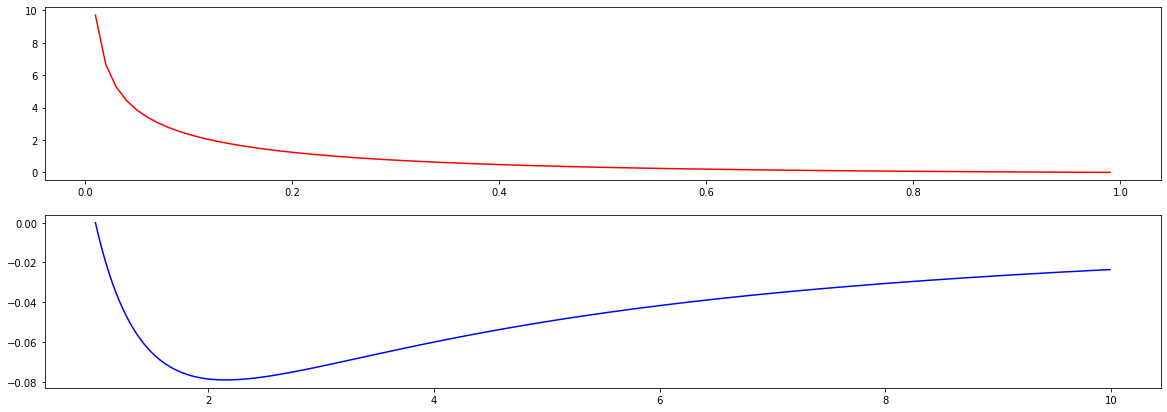

In [ ]:
fig, axs = plt.subplots(2,1,figsize = (20,7))
axs[0].plot(R_minus, IL_derivada_R(R_minus), c='red')
axs[1].plot(R_plus, IL_derivada_R(R_plus), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P(R_plus*P_entry), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs[0].plot(R_minus, IL_derivada_R_fee(R_minus, fee), c='red')
# axs[1].plot(R_plus, IL_derivada_R_fee(R_plus, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_fee(R_plus*P_entry, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

# Datos historicos de ETH

En esta sección armamos una función para traer datos históricos de Binance para varias frecuencias temporales. Notar que seteamos initial_date = '31 Mar 2021' pero uno puede poner la fecha de inicio que desee.

In [ ]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 15.8 MB/s 
     |████████████████████████████████| 112 kB 64.0 MB/s 
     |████████████████████████████████| 288 kB 70.7 MB/s 
     |████████████████████████████████| 271 kB 81.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 57.3 MB/s 
     |████████████████████████████████| 749 kB 27.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = '9zFIgetckRO80d4RciWs8jc4XSwAMEnFIuwVhAoaYIstQ9RWlfqiV6zcAGu0Ta8R'    #Enter your own API-key here
binance_api_secret = 'Uu8vtNEmH1PPDPDchX51jivxBENEbNwDmDcQrnhPJBJwFcbqjnvxL2MeQJuTc4Kg' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}

batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

# initial_date = '1 Jan 2017'
initial_date = '31 Mar 2021'
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime(initial_date, '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime(initial_date, '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


Nos quedamos con datos históricos para ETHUSDC con frecuencia de 5m.

In [ ]:
# lista = ["ETHUSDC"]

# BTC ETH MATIC UNI COMP AAVE YFI CRV MKR LINK KP3R SFI SUSHI 1INCH CAKE 
symbol = "ETHUSDC"
# Frecuencia: 1m, 5m, 10m, 15m, 1h, 1d, 1m
freq = "5m"

# Descarga de datos
ETH_historico = get_all_binance(symbol, freq, save = True)

All caught up..!


In [ ]:
len(ETH_historico)

133339

In [ ]:
ETH_historico

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2021-03-31 00:00:00,1841.29000000,1845.35000000,1841.12000000,1845.35000000,13.45650000,1617149099999,24811.47621960,39,4.46207000,8228.10868710,0
2021-03-31 00:05:00,1844.39000000,1847.08000000,1843.99000000,1846.29000000,54.69818000,1617149399999,100898.41600010,50,18.71127000,34521.30106140,0
2021-03-31 00:10:00,1845.54000000,1849.53000000,1845.54000000,1848.96000000,10.56434000,1617149699999,19523.84183440,31,6.35202000,11739.72432620,0
2021-03-31 00:15:00,1848.96000000,1850.35000000,1847.50000000,1847.50000000,126.93107000,1617149999999,234808.65135190,117,70.35710000,130155.06817220,0
2021-03-31 00:20:00,1848.12000000,1849.12000000,1846.00000000,1846.00000000,16.03979000,1617150299999,29631.68322550,61,3.04496000,5630.11817930,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-07 12:50:00,1186.35000000,1188.46000000,1185.67000000,1187.86000000,1590.46130000,1657198499999,1889259.19900500,833,138.16200000,164048.93580400,0
2022-07-07 12:55:00,1187.79000000,1188.40000000,1185.89000000,1186.37000000,166.55710000,1657198799999,197708.14141200,270,66.26460000,78653.06631000,0
2022-07-07 13:00:00,1186.44000000,1197.99000000,1186.07000000,1188.24000000,1314.95700000,1657199099999,1563837.96491700,918,1028.80510000,1223933.84054100,0


# Simulación del balance del pool wETH-USDC y de nuestras tenencias

Vamos a definir el balance inicial del pool con $50000$ unidades de ETH y $50000*P_{ETH_0}$ USDC, con $P_{ETH_0}$ el precio de mercado de ETH al momento de iniciar el pool. Nosotros tomaremos $P_{ETH_0}$ como el primer precio histórico. 

Recordar que en un protocolo de producto constante como es Balancer (cuando la cantidad de tokens en el pool es $n=2$ y los pesos son $w_i=0.5$) el precio relativo del pool es $P_{pool} = \frac{balance\_USDC}{balance\_ETH}$ con lo cual el precio al iniciar el pool es exactamente $P_{ETH_0}$.

Dado que los datos históricos son demasiados, nos quedamos con los ultimos 2000 datos.

In [ ]:
P_ETH = ETH_historico[:2000]['close']
for i in range(len(P_ETH)):
  P_ETH[i] = float(P_ETH[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


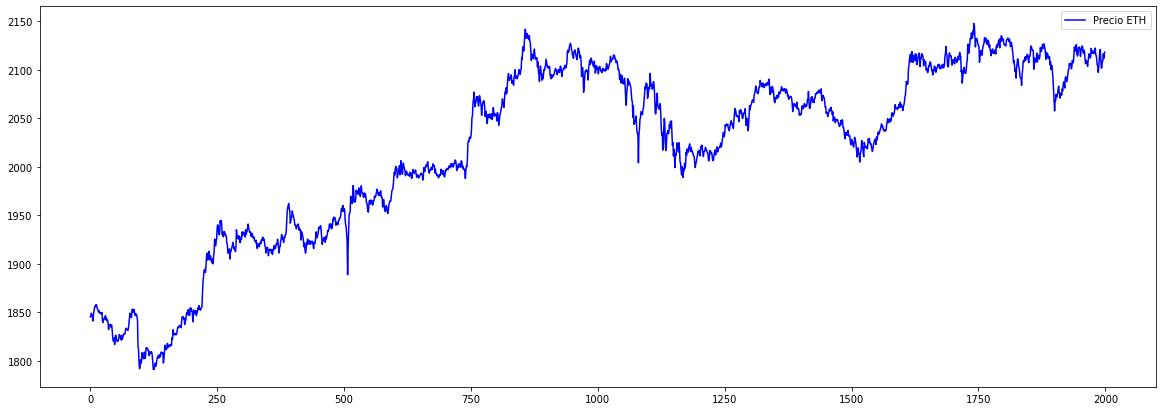

In [ ]:
# plt.plot(list(P_ETH))
# plt.figsize(20,7)
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(list(P_ETH), c='blue', label = 'Precio ETH')
axs.legend()

A continuación, definimos el balance inicial del pool con los datos que especificamos al comienzo y simularemos sus variaciones por medio de las funcion new_balance si este cambiara cada vez que se actualiza el precio de mercado (5m).

Además, para cada nuevo balance calcularemos su variación respecto del balance anterior utilizando la función variacion_balances, para aplicar estas variaciones a nuestras tenencias iniciales.

Además, utilizando las funciones new_balance y variacion_balances vamos a calcular cómo iría variando el balance del pool 

**Observacion**

Notar que en la vida real los balances no tienen por qué cambiar cada vez que el precio de mercado cambia, sino que lo hará cuando los arbitradores consideren que el gap entre P_pool y P_new justifica el esfuerzo. Sin embargo, la idea es simular cambios en nuestras tenencias para ver cómo se comporta la IL y desarrollar una estrategia de hedgeo. Mientras respetemos la geometría subyacente al pool, la IL que emerja será lo suficientemente representativa.


In [ ]:
P_entry = P_ETH[0]
balance_inicial = [P_entry*50000, 50000]
nuevos_balances = [balance_inicial]
variacion_balance_pcg = [[0,0]]
variacion_balance_unidades = [[0,0]]
for i in range(1,len(P_ETH)):
  P = P_ETH[i]
  nuevos_balances.append(new_balance(P, nuevos_balances[i-1]))
  variacion_balance_pcg.append(variacion_balances(nuevos_balances[i], nuevos_balances[i-1])['pcg'])
  variacion_balance_unidades.append(variacion_balances(nuevos_balances[i], nuevos_balances[i-1])['unidades'])

In [ ]:
balance_inicial[0]*2

184535000.0

Chequeamos que la variacion de los nuevos balances sea acorde a las variaciones teóricas.

In [ ]:
i = 15
nuevos_balances[i][0]/nuevos_balances[i-1][0] -1, variacion_balance_pcg[i][0]

(-0.00016729016134897634, -0.00016729016134897634)

Chequeamos que P_pool coincida con P_ETH (P de mercado)

In [ ]:
i = 15
nuevos_balances[i][0] / nuevos_balances[i][1], P_ETH[i] 

(1852.9099999826547, 1852.91)

Ahora sí, seteamos nuestras tenencias iniciales respetando nuevamente que el cociente de las mismas refleje el precio del mercado en ese momento.

In [ ]:
tenencias_inicial = [P_entry*100,100]
tenencias = [tenencias_inicial]
for i in range(len(variacion_balance_pcg)-1):
  tenencias.append([tenencias[i][0]*(1+variacion_balance_pcg[i+1][0]), tenencias[i][1]*(1+variacion_balance_pcg[i+1][1])])

Volvemos a chequear las dos cosas que chequeamos en los balances.

In [ ]:
i = 100
tenencias[i][0] / tenencias[i-1][0] -1, variacion_balance_pcg[i][0]

(-0.0010314798635737699, -0.0010314798635737699)

In [ ]:
i = 16
tenencias[i][0] / tenencias[i][1], P_ETH[i]

(1850.3699988059277, 1850.37)

# ¿Es lo mismo calcular IL como la diferencia entre V_P y V_H que tomar las formulas? NO!

Como mencionamos cuando definimos las formulas para la IL y su derivada, ciertas formulaciones equivalentes usaban el hecho de que $k(t)=k(0)$ para todo $t$. Veamos que esto podría ser un error.

In [ ]:
V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P_ETH
V_pool = [tenencias[i][0]+tenencias[i][1]*P_ETH[i] for i in range(len(tenencias))]
IL_formula = IL_P_in_usd(P_ETH)
IL_usd = [V_pool[i] - V_hold[i] for i in range(len(V_pool))]
diferencias = pd.DataFrame([IL_usd[i]-IL_formula[i] for i in range(len(P_ETH))], index = P_ETH.index)
comparacion_IL = pd.concat([pd.DataFrame(IL_usd, index = P_ETH.index), 
                            pd.DataFrame(IL_formula, index = P_ETH.index),
                            diferencias], axis = 1)
comparacion_IL.columns = ['IL_usd', 'IL_formula', 'Diferencias']
comparacion_IL

,IL_usd,IL_formula,Diferencias
timestamp,,,
2021-03-31 00:00:00,0.000000,-0.0,4.097500e-11
2021-03-31 00:05:00,-0.011968,-0.011968,3.664713e-11
2021-03-31 00:10:00,-0.176381,-0.176381,1.222279e-10
2021-03-31 00:15:00,-0.120197,-0.062587,-5.760967e-02
2021-03-31 00:20:00,-0.124191,-0.005723,-1.184686e-01
...,...,...,...
2021-04-06 22:15:00,-1448.104708,-879.642836,-5.684619e+02
2021-04-06 22:20:00,-1496.282993,-926.848892,-5.694341e+02
2021-04-06 22:25:00,-1466.760059,-897.486997,-5.692731e+02


Analicemos de dónde proviene esa diferencias. 

Tenemos las siguientes fórmulas equivalentes para V_pool y V_hold.

Si suponemos $k\equiv cte$

\begin{align*}
  V_P &= 2\sqrt{kP} = 2\sqrt{kP_0}\sqrt{\frac{P}{P_0}} = V_P^0\sqrt{\frac{P}{P_0}},\\
  V_H &= \sqrt{kP_0}\left(\frac{P}{P_0}+1\right) = 2\sqrt{kP_0}\frac{1}{2}\left(\frac{P}{P_0}+1\right)=\frac{V_H^0}{2}\left(\frac{P}{P_0}+1\right).
\end{align*}

Notar que en las ultimas igualdades de cada formula estoy asumiendo que $k(t)=k(0)$.

A continuacion, llamo formula_IL a la primera igualdad de las formulas y formula_cte a la ultima igualdad.

In [ ]:
k= pd.DataFrame([i*j for i,j in tenencias])[0]

In [ ]:
V_hold_formula_IL = [(k[i]*P_entry)**(1/2)*(P_ETH[i]/P_entry+1) for i in range(len(k))]
V_hold_formula_cte = V_hold[0]/2*(P_ETH/P_entry + 1)
V_pool_formula_IL = [2*(k[i]*P_ETH[i])**(1/2) for i in range(len(k))]
V_pool_formula_cte = V_hold[0]*(P_ETH/P_entry)**(1/2)

In [ ]:
comparacion_V_H = pd.concat([pd.DataFrame(V_hold, index = P_ETH.index), 
                             pd.DataFrame(V_hold_formula_IL, index = P_ETH.index),
                             pd.DataFrame(V_hold_formula_cte, index = P_ETH.index)], axis = 1)
          #  pd.DataFrame([V_hold[i]-V_hold_2[i] for i in range(len(V_pool))], index = P_ETH.index)], axis = 1)
comparacion_V_H.columns = ['V_H', 'V_H_formula_IL', 'V_H_formula_cte']
comparacion_V_P = pd.concat([pd.DataFrame(V_pool, index = P_ETH.index), 
                             pd.DataFrame(V_pool_formula_IL, index = P_ETH.index),
                             pd.DataFrame(V_pool_formula_cte, index = P_ETH.index)], axis = 1)
          #  pd.DataFrame([V_hold[i]-V_hold_2[i] for i in range(len(V_pool))], index = P_ETH.index)], axis = 1)
comparacion_V_P.columns = ['V_P', 'V_P_formula_IL', 'V_P_formula_cte']
pd.concat([comparacion_V_H, comparacion_V_P], axis = 1)

,V_H,V_H_formula_IL,V_H_formula_cte,V_P,V_P_formula_IL,V_P_formula_cte
timestamp,,,,,,
2021-03-31 00:00:00,369070.0,369070.000000,369070.0,369070.000000,369070.000000,369070.0
2021-03-31 00:05:00,369164.0,369164.000000,369164.0,369163.988032,369163.988032,369163.988032
2021-03-31 00:10:00,369431.0,369431.000000,369431.0,369430.823619,369430.823619,369430.823619
2021-03-31 00:15:00,369285.0,369284.942390,369285.0,369284.879803,369284.879803,369284.937413
2021-03-31 00:20:00,369135.0,369134.881531,369135.0,369134.875809,369134.875809,369134.994277
...,...,...,...,...,...,...
2021-04-06 22:15:00,395431.0,394861.270756,395431.0,393982.895292,393982.895292,394551.357164
2021-04-06 22:20:00,396153.0,395582.230513,396153.0,394656.717007,394656.717007,395226.151108
2021-04-06 22:25:00,395706.0,395135.432854,395706.0,394239.239941,394239.239941,394808.513003


Vemos entonces que V_H =! V_H_formula_IL pero V_H == V_H_formula_cte y V_P == V_P_formula_IL pero V_P =! V_P_formula_cte. Evidentemente V_P =! V_P_formula_cte porque $k(t)\neq k(0)$, lo curioso es que V_H == V_H_formula_cte.

Veamos que efectivamente $k(t)\neq k(0)$.

In [ ]:
bool(np.prod([k[i] == k[0] for i in range(len(k))]))

False

De hecho, a continuacion vemos que hay mucha diferencias a medida que $t$ (i) aumenta.

In [ ]:
diferencias = pd.DataFrame([k[i]-k[0] for i in range(len(k))], index = P_ETH.index)
comparacion_k = pd.concat([pd.DataFrame([k[i] for i in range(len(k))], index = P_ETH.index), 
                            pd.DataFrame([k[0]]*len(k), index = P_ETH.index),
                            diferencias], axis = 1)
comparacion_k.columns = ['k', 'k[0]', 'Diferencias']
comparacion_k

,k,k[0],Diferencias
timestamp,,,
2021-03-31 00:00:00,1.845350e+07,18453500.0,0.000000e+00
2021-03-31 00:05:00,1.845350e+07,18453500.0,3.725290e-09
2021-03-31 00:10:00,1.845350e+07,18453500.0,3.725290e-09
2021-03-31 00:15:00,1.845349e+07,18453500.0,-5.757613e+00
2021-03-31 00:20:00,1.845349e+07,18453500.0,-1.184477e+01
...,...,...,...
2021-04-06 22:15:00,1.840036e+07,18453500.0,-5.313658e+04
2021-04-06 22:20:00,1.840036e+07,18453500.0,-5.313658e+04
2021-04-06 22:25:00,1.840032e+07,18453500.0,-5.317771e+04


Entonces para armar nuestra estrategia, como queremos usar las fórmulas de IL y IL_derivada, debemos tener en cuenta 
$$k(t) = tenencias(t)[0]*tenencias(t)[1],$$
en cada momento.

Si suponemos que $k$ puede cambiar entonces las fórmulas para V_P y V_H quedan

\begin{align*}
  V_P(t) &= 2\sqrt{k(t)P(t)} = 2\sqrt{k(0)P(0)}\sqrt{\frac{k(t)P(t)}{k(0)P(0)}}\\ 
  &= V_P(0)\sqrt{\frac{k(t)}{k(0)}}\sqrt{\frac{P(t)}{P(0)}},\\
  V_H(t) &= \sqrt{k(t)P(0)}\left(\frac{P(t)}{P(0)}+1\right) = 2\sqrt{k(0)P(0)}\sqrt{\frac{k(t)}{k(0)}}\frac{1}{2}\left(\frac{P(t)}{P(0)}+1\right)\\
  &=\frac{V_H(0)}{2}\sqrt{\frac{k(t)}{k(0)}}\left(\frac{P}{P_0}+1\right).
\end{align*}


In [ ]:
V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P_ETH
V_hold_formula_IL_k = [(k[i]*P_entry)**(1/2)*(P_ETH[i]/P_entry+1) for i in range(len(k))]
V_hold_formula_cte_k = [V_hold[0]/2*(k[i]/k[0])**(1/2)*(P_ETH[i]/P_entry + 1) for i in range(len(k))]
V_pool = [tenencias[i][0]+tenencias[i][1]*P_ETH[i] for i in range(len(tenencias))]
V_pool_formula_IL_k = [2*(k[i]*P_ETH[i])**(1/2) for i in range(len(k))]
V_pool_formula_cte_k = [V_hold[0]*(k[i]/k[0])**(1/2)*(P_ETH[i]/P_entry)**(1/2) for i in range(len(k))]

In [ ]:
comparacion_V_H_k = pd.concat([pd.DataFrame(V_hold, index = P_ETH.index), 
                             pd.DataFrame(V_hold_formula_IL_k, index = P_ETH.index),
                             pd.DataFrame(V_hold_formula_cte_k, index = P_ETH.index)], axis = 1)
          #  pd.DataFrame([V_hold[i]-V_hold_2[i] for i in range(len(V_pool))], index = P_ETH.index)], axis = 1)
comparacion_V_H_k.columns = ['V_H', 'V_H_formula_IL_k', 'V_H_formula_cte_k']
comparacion_V_P_k = pd.concat([pd.DataFrame(V_pool, index = P_ETH.index), 
                             pd.DataFrame(V_pool_formula_IL_k, index = P_ETH.index),
                             pd.DataFrame(V_pool_formula_cte_k, index = P_ETH.index)], axis = 1)
          #  pd.DataFrame([V_hold[i]-V_hold_2[i] for i in range(len(V_pool))], index = P_ETH.index)], axis = 1)
comparacion_V_P_k.columns = ['V_P', 'V_P_formula_IL_k', 'V_P_formula_cte_k']
pd.concat([comparacion_V_H_k, comparacion_V_P_k], axis = 1)

,V_H,V_H_formula_IL_k,V_H_formula_cte_k,V_P,V_P_formula_IL_k,V_P_formula_cte_k
timestamp,,,,,,
2021-03-31 00:00:00,369070.0,369070.000000,369070.000000,369070.000000,369070.000000,369070.000000
2021-03-31 00:05:00,369164.0,369164.000000,369164.000000,369163.988032,369163.988032,369163.988032
2021-03-31 00:10:00,369431.0,369431.000000,369431.000000,369430.823619,369430.823619,369430.823619
2021-03-31 00:15:00,369285.0,369284.942390,369284.942390,369284.879803,369284.879803,369284.879803
2021-03-31 00:20:00,369135.0,369134.881531,369134.881531,369134.875809,369134.875809,369134.875809
...,...,...,...,...,...,...
2021-04-06 22:15:00,395431.0,394861.270756,394861.270756,393982.895292,393982.895292,393982.895292
2021-04-06 22:20:00,396153.0,395582.230513,395582.230513,394656.717007,394656.717007,394656.717007
2021-04-06 22:25:00,395706.0,395135.432854,395135.432854,394239.239941,394239.239941,394239.239941


Vemos que ahora V_H_formula_IL_k == V_H_formula_cte_k pero distintas a V_H y que V_P = V_H_formula_IL_k == V_H_formula_cte_k.

Incorporemos entonces las funciones que tienen en cuenta el factor $\sqrt{\frac{k(t)}{k(0)}}$ y volvamos a ver cómo dan las cuentas. Por lo anterior, meteremos el término $\sqrt{\frac{k(t)}{k(0)}}$ sólo en V_P.

In [ ]:
def IL_P_in_usd_k(P,k):
  # return IL_R(P/P_entry)
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  k_0 = tenencias_inicial[0]*tenencias_inicial[1]
  return V_hold_0 * ( (k/k_0)**(1/2) * (P/P_entry)**(1/2) - 1/2 - P/(2*P_entry) )
def IL_derivada_P_in_usd_k(P,k):
  k_0 = tenencias_inicial[0]*tenencias_inicial[1]
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  # return IL_derivada_P(P)*V_hold + IL_P(P)*tenencias_inicial[1]
  return V_hold_0/(2*P_entry) * ( (k/k_0)**(1/2) * (P_entry/P)**(1/2) - 1 )

In [ ]:
IL_formula_k = [IL_P_in_usd_k(P_ETH[i],k[i]) for i in range(len(P_ETH))]
diferencias_k = pd.DataFrame([IL_usd[i]-IL_formula_k[i] for i in range(len(P_ETH))], index = P_ETH.index)
comparacion_IL_k = pd.concat([pd.DataFrame(IL_usd, index = P_ETH.index), 
                            pd.DataFrame(IL_formula_k, index = P_ETH.index),
                            diferencias_k], axis = 1)
comparacion_IL_k.columns = ['IL_usd', 'IL_formula_k', 'Diferencias_k']
comparacion_IL_k

,IL_usd,IL_formula_k,Diferencias_k
timestamp,,,
2021-03-31 00:00:00,0.000000,0.000000,0.000000e+00
2021-03-31 00:05:00,-0.011968,-0.011968,8.784307e-12
2021-03-31 00:10:00,-0.176381,-0.176381,1.054479e-10
2021-03-31 00:15:00,-0.120197,-0.120197,-2.112932e-11
2021-03-31 00:20:00,-0.124191,-0.124191,8.434409e-11
...,...,...,...
2021-04-06 22:15:00,-1448.104708,-1448.104708,-3.524292e-11
2021-04-06 22:20:00,-1496.282993,-1496.282993,-7.003109e-11
2021-04-06 22:25:00,-1466.760059,-1466.760059,7.048584e-12


Ahora si se observa que los cálculos coinciden. 

Ya podemos armar la estrategia usando IL_P_in_usd_k y IL_derivada_P_in_usd_k.